This notebook deals with the target variable that has previously been transformed into a categorical variable through the use of binning. This categorical target variable will have classification models run to predict it. These models will be fine-tuned to find the best performing model.

#Read in data

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('Classification_data.csv', index_col=0, skipinitialspace = True)
data.head(3)

,area,GUID,GEOGID,GEOGDESC,Binned Income
0,Carlow Urban,2AE19629185813A3E055000000000001,ED3409_01001,Carlow Urban,High
1,Graigue Urban,2AE196291A5913A3E055000000000001,ED3409_01002,Graigue Urban,High
2,Clonmore,2AE19629186413A3E055000000000001,ED3409_01003,Clonmore,High


Isolate target variable

In [ ]:
x = data.iloc[:, :4]
x.head(3)

,area,GUID,GEOGID,GEOGDESC
0,Carlow Urban,2AE19629185813A3E055000000000001,ED3409_01001,Carlow Urban
1,Graigue Urban,2AE196291A5913A3E055000000000001,ED3409_01002,Graigue Urban
2,Clonmore,2AE19629186413A3E055000000000001,ED3409_01003,Clonmore


Remove leading and trailing whitespace from categorical columns

In [ ]:
x.loc[:, 'area'] = x['area'].str.strip()
x.loc[:, 'GEOGDESC'] = x['GEOGDESC'].str.strip()
x.loc[:, 'GUID'] = x['GUID'].str.strip()
x.loc[:, 'GEOGID'] = x['GEOGID'].str.strip()
x.head(3)

,area,GUID,GEOGID,GEOGDESC
0,Carlow Urban,2AE19629185813A3E055000000000001,ED3409_01001,Carlow Urban
1,Graigue Urban,2AE196291A5913A3E055000000000001,ED3409_01002,Graigue Urban
2,Clonmore,2AE19629186413A3E055000000000001,ED3409_01003,Clonmore


In [ ]:
y = data[['Binned Income']]
y

,Binned Income
0,High
1,High
2,High
3,High
4,High
...,...
3404,Low
3405,Low
3406,Low
3407,Low


## Train Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x,
                                                  y,
                                                  test_size=0.10,
                                                  shuffle=True,
                                                  random_state=324
                                                 )

# Install algorithms

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
from sklearn.svm import SVC
svm = SVC()
from sklearn.ensemble import BaggingClassifier
bag = BaggingClassifier()
from xgboost.sklearn import XGBClassifier
xgb = XGBClassifier()
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

# Encode data

Data is encoded to make it suitable for machine learning algorithms

In [ ]:
# define ordinal encoding
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
# transform data
X_train = encoder.fit_transform(X_train)
y_train = encoder.fit_transform(y_train)
X_val = encoder.fit_transform(X_val)
y_val = encoder.fit_transform(y_val)

# Run models

In [ ]:
models = [dt, rf, knn, svm, bag, xgb, nb, lr]

In [ ]:
from sklearn import metrics

In [ ]:
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning

# Suppress specific warnings
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
model_eval = []
for model in models:
  model = model.fit(X_train, y_train)
  predictions = model.predict(X_val)

  type(predictions)
  accuracy = metrics.accuracy_score(y_val, predictions)

  model_eval.append({'Model': model, 'Accuracy': accuracy})

df = pd.DataFrame(model_eval)
df

,Model,Accuracy
0,DecisionTreeClassifier(),0.026393
1,"(DecisionTreeClassifier(max_features='sqrt', r...",0.043988
2,KNeighborsClassifier(),0.020528
3,SVC(),0.020528
4,(DecisionTreeClassifier(random_state=113792077...,0.026393
5,"XGBClassifier(base_score=None, booster=None, c...",0.020528
6,GaussianNB(),0.020528
7,LogisticRegression(),0.718475


In [ ]:
model = LogisticRegression()
y_true = y_val
y_pred = lr.predict(X_val)
y_score = lr.predict_proba(X_val)[:, 1]

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_val, y_score, pos_label=1)

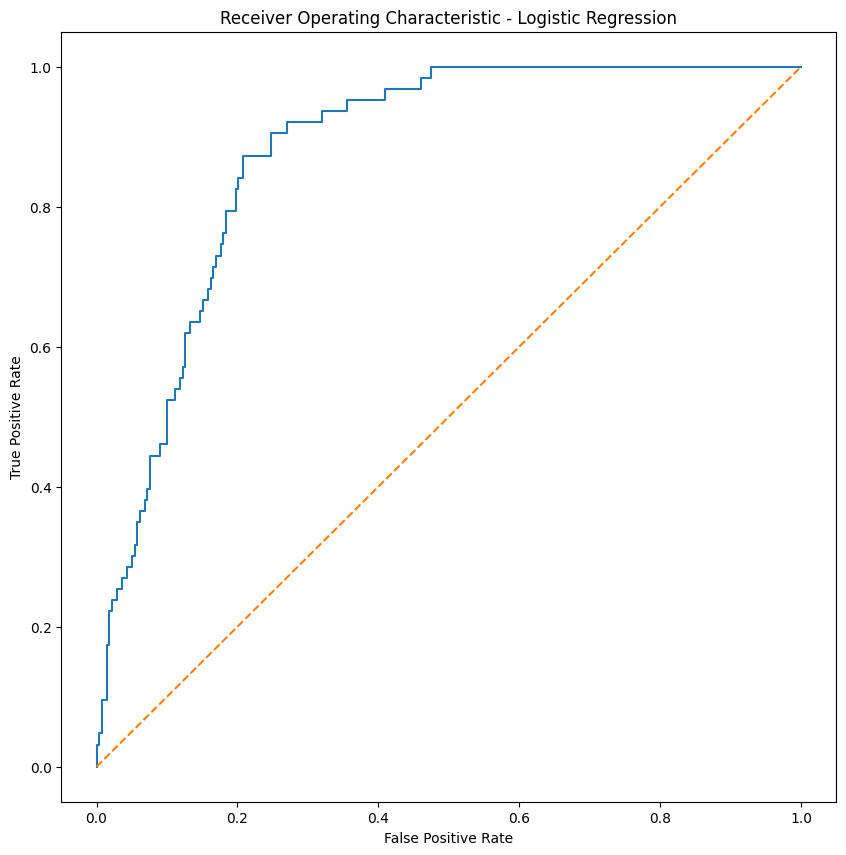

In [ ]:
import matplotlib.pyplot as plt
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(false_positive_rate1, true_positive_rate1)
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Tune best model

In [ ]:
# define models and parameters
model = LogisticRegression(max_iter=1000)
solvers = ['newton-cg', 'lbfgs']  # Keep solvers that match with valid penalties
penalties = ['l2', 'l1', 'elasticnet', 'none']  # Supported penalties
c_values = [10, 1.0, 0.1]
# Create a valid parameter grid by filtering out incompatible solver-penalty pairs
param_grid = []
for solver in solvers:
    if solver in ['newton-cg', 'lbfgs']:
        param_grid.append({'solver': [solver], 'penalty': ['l2', 'none'], 'C': c_values})
    elif solver == 'liblinear':
        param_grid.append({'solver': [solver], 'penalty': ['l1', 'l2'], 'C': c_values})
    elif solver == 'saga':
        param_grid.append({'solver': [solver], 'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'C': c_values})

In [ ]:
# Define cross-validation method
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=1)

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='accuracy', error_score=0)

# Fit the model
grid_result = grid_search.fit(X_train, y_train.ravel())  # Ensure y_train is 1D

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:313: LineSearchWarning: The line search algorithm did not converge
  alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:44: LineSearchWarning: The line search algorithm did not converge
  ret = line_search_wolfe2(


In [ ]:
grid_result

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=3, random_state=1),
             error_score=0, estimator=LogisticRegression(max_iter=1000),
             n_jobs=-1,
             param_grid=[{'C': [10, 1.0, 0.1], 'penalty': ['l2', 'none'],
                          'solver': ['newton-cg']},
                         {'C': [10, 1.0, 0.1], 'penalty': ['l2', 'none'],
                          'solver': ['lbfgs']}],
             scoring='accuracy')

In [ ]:
# print best parameter after tuning
print(grid_result.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid_result.best_estimator_)

{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
LogisticRegression(C=10, max_iter=1000, solver='newton-cg')


Fit best model

In [ ]:
model3 = LogisticRegression(C=10, penalty='l2',solver='newton-cg')
model3 = model3.fit(X_train, y_train)
predictions = model3.predict(X_val)
accuracy = metrics.accuracy_score(y_val, predictions)
print(f'Model: {model3}, Accuracy: {accuracy}')

Model: LogisticRegression(C=10, solver='newton-cg'), Accuracy: 0.21994134897360704
